# 08. Model Classification: Training - PySpark

## 08.1. Importação das bibliotecas

### 08.1.1. Importando as bibliotecas nativas do Python

In [1]:
import sys
import warnings

### 08.1.2. Importando as bibliotecas de terceiros

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from pyspark.sql import SparkSession, types as T
from pyspark.sql.functions import *
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, StandardScaler

### 08.1.3. Importando os módulos locais do projeto

In [3]:
sys.path.append('..')
import functions.fn_charts_pandas as fn_charts_pandas
import functions.fn_stats_pyspark as fn_stats_pyspark
import params.consts as consts

## 08.2. Visão geral dos dados

### 08.2.0. Iniciando a sessão Spark

In [4]:
spark = SparkSession.builder.appName('spark').getOrCreate()

### 08.2.1. Habilitando a exibição de todas as colunas

In [5]:
pd.set_option('display.max_columns', None)

### 08.2.2. Armazenando o dataset em uma variável

In [6]:
df = spark.read \
    .format('parquet') \
    .load(consts.DATASET_CLUSTERED_PYSPARK)

### 08.2.3. Visualizando a quantidade de linhas e colunas do dataset

In [7]:
(df.count(), len(df.columns))

(2205, 23)

### 08.2.4. Exibindo o dataset

In [8]:
df.show(5)

+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
| Education|Marital_Status|Children|HasChildren|Age|AgeGroup| Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|Cluster|
+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|       PhD|        Single|       0|          0| 40|   31-45|63159.0|     74|  

### 08.2.5. Visualizando os detalhes do dataset

In [9]:
df.printSchema()

root
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Children: integer (nullable = true)
 |-- HasChildren: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Income: double (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Complain: integer (nullable = true)
 |-- Dt_Customer_Month: integer (nullable = true)
 |-- Dt_Customer_Quarter: integer (nullable = true)
 |-- Days_Since_Enrolled: integer (nullable = true)
 |-- Years_Since_Enrolled: long (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- NumTotalPurchases: integer (nullable = true)
 |-- MntRegularProds: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- MntTotal: integer (nullable = true)
 |-- AcceptedCmpTotal: integer (nullable = true)
 |-- HasAcceptedCmp: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-

### 08.2.6. Visualizando as estatísticas das colunas numéricas

In [10]:
fn_stats_pyspark.summary(df).show(truncate = False)

+-------+---------+--------------+--------+-----------+------+--------+--------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|summary|Education|Marital_Status|Children|HasChildren|Age   |AgeGroup|Income  |Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|Cluster|
+-------+---------+--------------+--------+-----------+------+--------+--------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|count  |2205     |2205          |2205.0  |220

### 08.2.7. Visualizando as estatísticas da colunas categóricas

In [11]:
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, T.StringType)]

df.describe(categorical_columns).show()

+-------+---------+--------------+--------+
|summary|Education|Marital_Status|AgeGroup|
+-------+---------+--------------+--------+
|  count|     2205|          2205|    2205|
|   mean|     NULL|          NULL|    NULL|
| stddev|     NULL|          NULL|    NULL|
|    min| 2n Cycle|       Partner|   18-30|
|    max|      PhD|        Single|     61+|
+-------+---------+--------------+--------+



### 08.2.8. Verificando as colunas com valores nulos

In [12]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------------+--------+-----------+---+--------+------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|Education|Marital_Status|Children|HasChildren|Age|AgeGroup|Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|Cluster|
+---------+--------------+--------+-----------+---+--------+------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|        0|             0|       0|          0|  0|       0|     0|      0|       0| 

## 08.3. Treinamento do modelo de classificação

### 08.3.0. Convertendo o df PySpark para Pandas

In [13]:
df_pd = df.toPandas()

### 08.3.1. Definindo os valores de X e y

In [14]:
X = df.drop('Response')

X_pd = X.toPandas()

X.show(5)

+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+-------+
| Education|Marital_Status|Children|HasChildren|Age|AgeGroup| Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Cluster|
+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+-------+
|       PhD|        Single|       0|          0| 40|   31-45|63159.0|     74|       0|               11|  

In [15]:
y = df.select('Response')

y_pd = y.toPandas()['Response']

y.show(5)

+--------+
|Response|
+--------+
|       0|
|       1|
|       0|
|       0|
|       0|
+--------+
only showing top 5 rows


### 08.3.2. Listando as colunas numéricas e categóricas

In [16]:
numerical_features = X_pd.select_dtypes(include = 'number').columns 

print('Numerical Features:') 

for i in numerical_features:

    print(f'- {i}')

Numerical Features:
- Children
- HasChildren
- Age
- Income
- Recency
- Complain
- Dt_Customer_Month
- Dt_Customer_Quarter
- Days_Since_Enrolled
- Years_Since_Enrolled
- NumDealsPurchases
- NumWebVisitsMonth
- NumTotalPurchases
- MntRegularProds
- MntGoldProds
- MntTotal
- AcceptedCmpTotal
- HasAcceptedCmp
- Cluster


In [17]:
categorical_features = X_pd.select_dtypes(exclude = 'number').columns 

print('\nCategorical Features:') 

for i in categorical_features:
    
    print(f'- {i}')


Categorical Features:
- Education
- Marital_Status
- AgeGroup


### 08.3.3. Criando histogramas para entender a distribuição de dados das colunas

- Gráfico: Histograma.


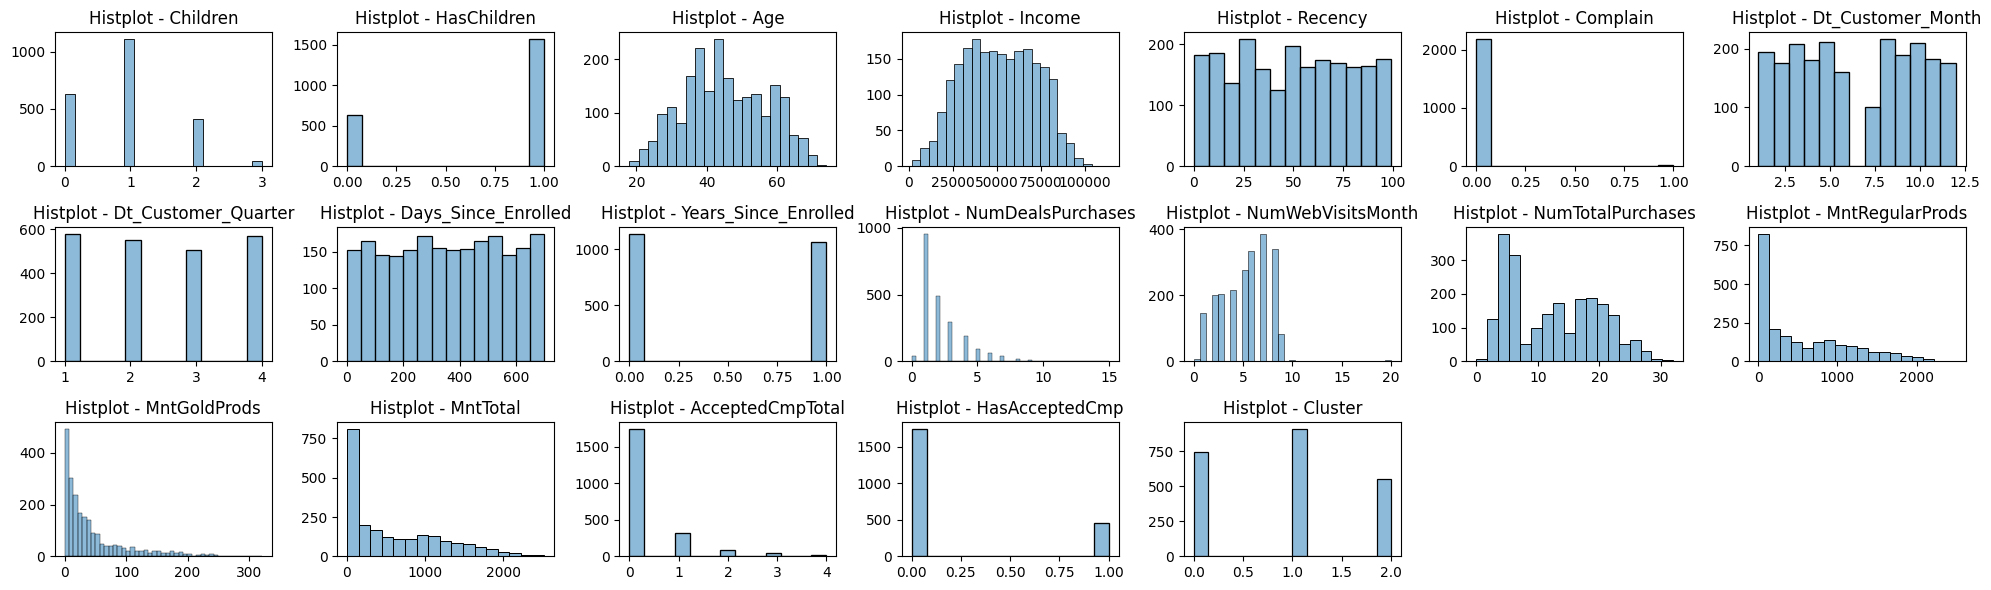

In [18]:
print('- Gráfico: Histograma.')

fn_charts_pandas.histplot(X_pd, numerical_features, num_cols = 7, height_figsize = 2)

plt.savefig(f'../images/outputs/charts/pyspark/nb08_histplot.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 08.3.4. Definindo o pré processamento das colunas de acordo com a distribuição dos seus dados

- **One Hot Encoder:** Indicado para colunas categóricas ou que possuem inteiros discretos.
- **Standard Scaler:** Indicado para colunas com distribuição semelhante à normal.
- **Power Transformer:** Indicado para colunas com assimetria dos dados.
- **Min-Max Scaler:** Indicado para colunas com distribuição uniforme dos dados.

In [19]:
one_hot_encoder_columns = [
    'Education',
    'Marital_Status',
    'AgeGroup',
    'Children',
    'HasChildren',
    'Complain',
    'Years_Since_Enrolled',
    'AcceptedCmpTotal',
    'HasAcceptedCmp',
    'Cluster',
]

standard_scaler_columns = [
    'Income',
    'Age',
]

power_transformer_columns = [
   'NumDealsPurchases',
   'NumWebVisitsMonth',
   'NumTotalPurchases',
   'MntRegularProds',
   'MntGoldProds',
   'MntTotal',
]

min_max_scaler_columns = [
    'Recency',
    'Dt_Customer_Month',
    'Dt_Customer_Quarter',
    'Days_Since_Enrolled',
]

### 08.3.5. Definindo os pré processamentos que serão aplicados nas colunas

In [20]:
pre_processing = ColumnTransformer([

    ('one_hot_encoder', OneHotEncoder(), one_hot_encoder_columns),

    ('standard_scaler', StandardScaler(), standard_scaler_columns),

    ('power_transformer', PowerTransformer(), power_transformer_columns),

    ('min_max_scaler', MinMaxScaler(), min_max_scaler_columns)

])

### 08.3.6. Criando o pipeline inicial

In [21]:
pipeline_initial = Pipeline([
        
    ('pre_processing', pre_processing), 

    ('feature_selection', SelectKBest(score_func = f_classif, k = 10)), 
    
    ('resampling', RandomUnderSampler(random_state = consts.RANDOM_STATE)), 
    
    ('models', LogisticRegression(random_state = consts.RANDOM_STATE)), 
    
])

### 08.3.7. Treinando o modelo inicial

In [22]:
pipeline_initial.fit(X_pd, y_pd)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'Children', 'HasChildren',
                                                   'Complain',
                                                   'Years_Since_Enrolled',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Cluster']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('power_transformer',
                                                  PowerTransformer(),
                                                  ['NumDealsPurchases',
                                                   'NumWebVisitsMonth',
                                                   'NumTotalPurchases',
                                                   'MntRegularProds',
                                                   'MntGoldProds',
                                                   'MntTotal']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Recency',
                                                   'Dt_Customer_Month',
                                                   'Dt_Customer_Quarter',
                                                   'Days_Since_Enrolled'])])),
                ('feature_selection', SelectKBest()),
                ('resampling', RandomUnderSampler(random_state=42)),
                ('models', LogisticRegression(random_state=42))])

### 08.3.8. Aplicando o pipeline no modelo inicial

In [23]:
scores_initial = cross_validate( 

    pipeline_initial, 

    X_pd, 

    y_pd, 

    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = consts.RANDOM_STATE), 
    
    scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'], 
    
    n_jobs = -2, 

)

## 08.4. Otimização dos hiperparâmetros

### 08.4.1. Definindo o Grid Search

In [24]:
grid_search = GridSearchCV( 

    Pipeline([
            
        ('pre_processing', pre_processing), 

        ('feature_selection', SelectKBest(score_func = f_classif, k = 10)), 
        
        ('resampling', RandomUnderSampler(random_state = consts.RANDOM_STATE)), 
        
        ('models', LogisticRegression(random_state = consts.RANDOM_STATE)), 
        
    ]), 
    
    { 

        'feature_selection__k': [10, 15, 20, 25],

        'models__C': np.logspace(-3, 3, 7),

        'models__solver': ['liblinear', 'lbfgs', 'saga'],

        'models__penalty': ['l1', 'l2', 'elasticnet', 'none']
        
    }, 
    
    scoring = ['roc_auc', 'average_precision', 'accuracy'], 
    
    n_jobs = -2, 
    
    refit = 'average_precision' 

)

### 08.4.2. Encontrando a melhor combinação de hiperparâmetros

In [25]:
warnings.filterwarnings('ignore') 

grid_search.fit(X_pd, y_pd) 

GridSearchCV(estimator=Pipeline(steps=[('pre_processing',
                                        ColumnTransformer(transformers=[('one_hot_encoder',
                                                                         OneHotEncoder(),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'AgeGroup',
                                                                          'Children',
                                                                          'HasChildren',
                                                                          'Complain',
                                                                          'Years_Since_Enrolled',
                                                                          'AcceptedCmpTotal',
                                                                          'HasAcceptedCmp',
                                                                          'Cluster']),
                                                                        ('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['Income',
                                                                          'Age']),
                                                                        ('power_transformer',
                                                                         Pow...
                                       ('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-2,
             param_grid={'feature_selection__k': [10, 15, 20, 25],
                         'models__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'models__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'models__solver': ['liblinear', 'lbfgs', 'saga']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

### 08.4.3. Listando os melhores hiperparâmetros

In [26]:
grid_search.best_params_ 

{'feature_selection__k': 25,
 'models__C': np.float64(1.0),
 'models__penalty': 'l2',
 'models__solver': 'lbfgs'}

## 08.5. Treinamento otimizado do modelo de classificação

### 08.5.1. Criando o pipeline final

In [27]:
pipeline_final = Pipeline([

    ('pre_processing', pre_processing), 

    ('feature_selection', SelectKBest(score_func = f_classif, k = grid_search.best_params_['feature_selection__k'])), 

    ('resampling', RandomUnderSampler(random_state = consts.RANDOM_STATE)), 
    
    ('models', LogisticRegression(

        random_state = consts.RANDOM_STATE,

        C = grid_search.best_params_['models__C'],

        penalty = grid_search.best_params_['models__penalty'],

        solver = grid_search.best_params_['models__solver'],

    )),
    
])

### 08.5.2. Treinando o modelo final

In [28]:
pipeline_final.fit(X_pd, y_pd)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'Children', 'HasChildren',
                                                   'Complain',
                                                   'Years_Since_Enrolled',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Cluster']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('power_transformer',
                                                  PowerTransformer(),
                                                  ['NumDe...
                                                   'NumWebVisitsMonth',
                                                   'NumTotalPurchases',
                                                   'MntRegularProds',
                                                   'MntGoldProds',
                                                   'MntTotal']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Recency',
                                                   'Dt_Customer_Month',
                                                   'Dt_Customer_Quarter',
                                                   'Days_Since_Enrolled'])])),
                ('feature_selection', SelectKBest(k=25)),
                ('resampling', RandomUnderSampler(random_state=42)),
                ('models',
                 LogisticRegression(C=np.float64(1.0), random_state=42))])

### 08.5.3. Aplicando o pipeline no modelo final

In [29]:
scores_final = cross_validate(

    pipeline_final, 
    
    X_pd, 
    
    y_pd, 
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = consts.RANDOM_STATE), 

    scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'], 
    
    n_jobs = -2, 

)

### 08.5.4. Evitando overfitting do modelo

- **Feature Selection:** No aspecto de Feature Selection, foi aplicado o SelectKBest para selecionar as melhores features (colunas) para a criação do modelo, de modo que estivessem somente as features mais relevantes para o modelo e que não houvesse dados redundantes.
- **Balanceamento de Classes:** No aspecto de Balanceamento de Classes, como o dataset do projeto é desbalanceado, foi aplicado a técnica de Random Under Sampling (RUS) para se equiparar os valores da classe target ('Response'), onde se reduz a quantidade de valores da classe majoritária até que fique igual aos valores da classe minoritária.
- **Validação Cruzada:** No aspecto de Validação Cruzada, foi aplicado o Stratified K-Fold, por ser um dataset desbalanceado, para dividir o conjunto de treinamento em várias partes (folds) e realizar o treinamento e validação do modelo em combinações diferentes desses folds, de modo que se obtém resultados mais confiáveis das métricas de avaliação do modelo e reduz o viés associado a uma única divisão do conjunto de treinamento.
- **Regularização:** No aspecto de Regularização, foi aplicado a regularização L2 (Ridge) para adicionar uma penalidade ao modelo com base no coeficientes dos parâmetros, de modo que os coeficientes se tornem muito grandes e assim reduzindo o overfitting.
- **Otimização de Hiperparâmetros:** No aspecto de Otimização de Hiperparâmetros, foi aplicado o Grid Search para se combinar os melhores parâmetros das etapas do pipeline, de modo que se obtenha os melhores resultados nas métricas de avaliação para ter um modelo com boa performance e evitar o overfitting.

## 08.6. Comparação entre versões

### 08.6.1. Criando um dataset com as métricas iniciais e finais do treinamento do modelo

In [30]:
df_metrics = pd.concat([

    pd.DataFrame(scores_initial).assign(time = lambda df: df['fit_time'] + df['score_time'], results = 'initial'),

    pd.DataFrame(scores_final).assign(time = lambda df: df['fit_time'] + df['score_time'], results = 'final'),
    
], ignore_index = True)

df_metrics = df_metrics.rename(columns = lambda c: c.replace('test_', ''))

df_metrics = df_metrics.drop(columns = ['fit_time', 'score_time'])

df_metrics = df_metrics.reindex(columns = ['results', 'accuracy', 'precision', 'recall', 'roc_auc', 'average_precision', 'time'])

df_metrics

,results,accuracy,precision,recall,roc_auc,average_precision,time
0,initial,0.773243,0.362903,0.681818,0.805091,0.506614,0.142929
1,initial,0.802721,0.413223,0.757576,0.874061,0.634979,0.134989
2,initial,0.770975,0.353448,0.611940,0.798348,0.423625,0.137334
3,initial,0.793651,0.375000,0.537313,0.757263,0.482502,0.142461
4,initial,0.764172,0.347107,0.626866,0.741560,0.438733,0.131785
5,final,0.804989,0.420635,0.803030,0.881253,0.633779,0.119335
6,final,0.823129,0.450000,0.818182,0.898465,0.665887,0.105894
7,final,0.780045,0.380952,0.716418,0.842924,0.555757,0.094358
8,final,0.777778,0.388489,0.805970,0.889756,0.679089,0.108287
9,final,0.798186,0.409836,0.746269,0.861002,0.604084,0.096797


### 08.6.2. Criando diagramas de caixa para comparar as métricas do modelo antes e depois da otimização de hiperparâmetros

- Gráfico: Diagrama de Caixa.


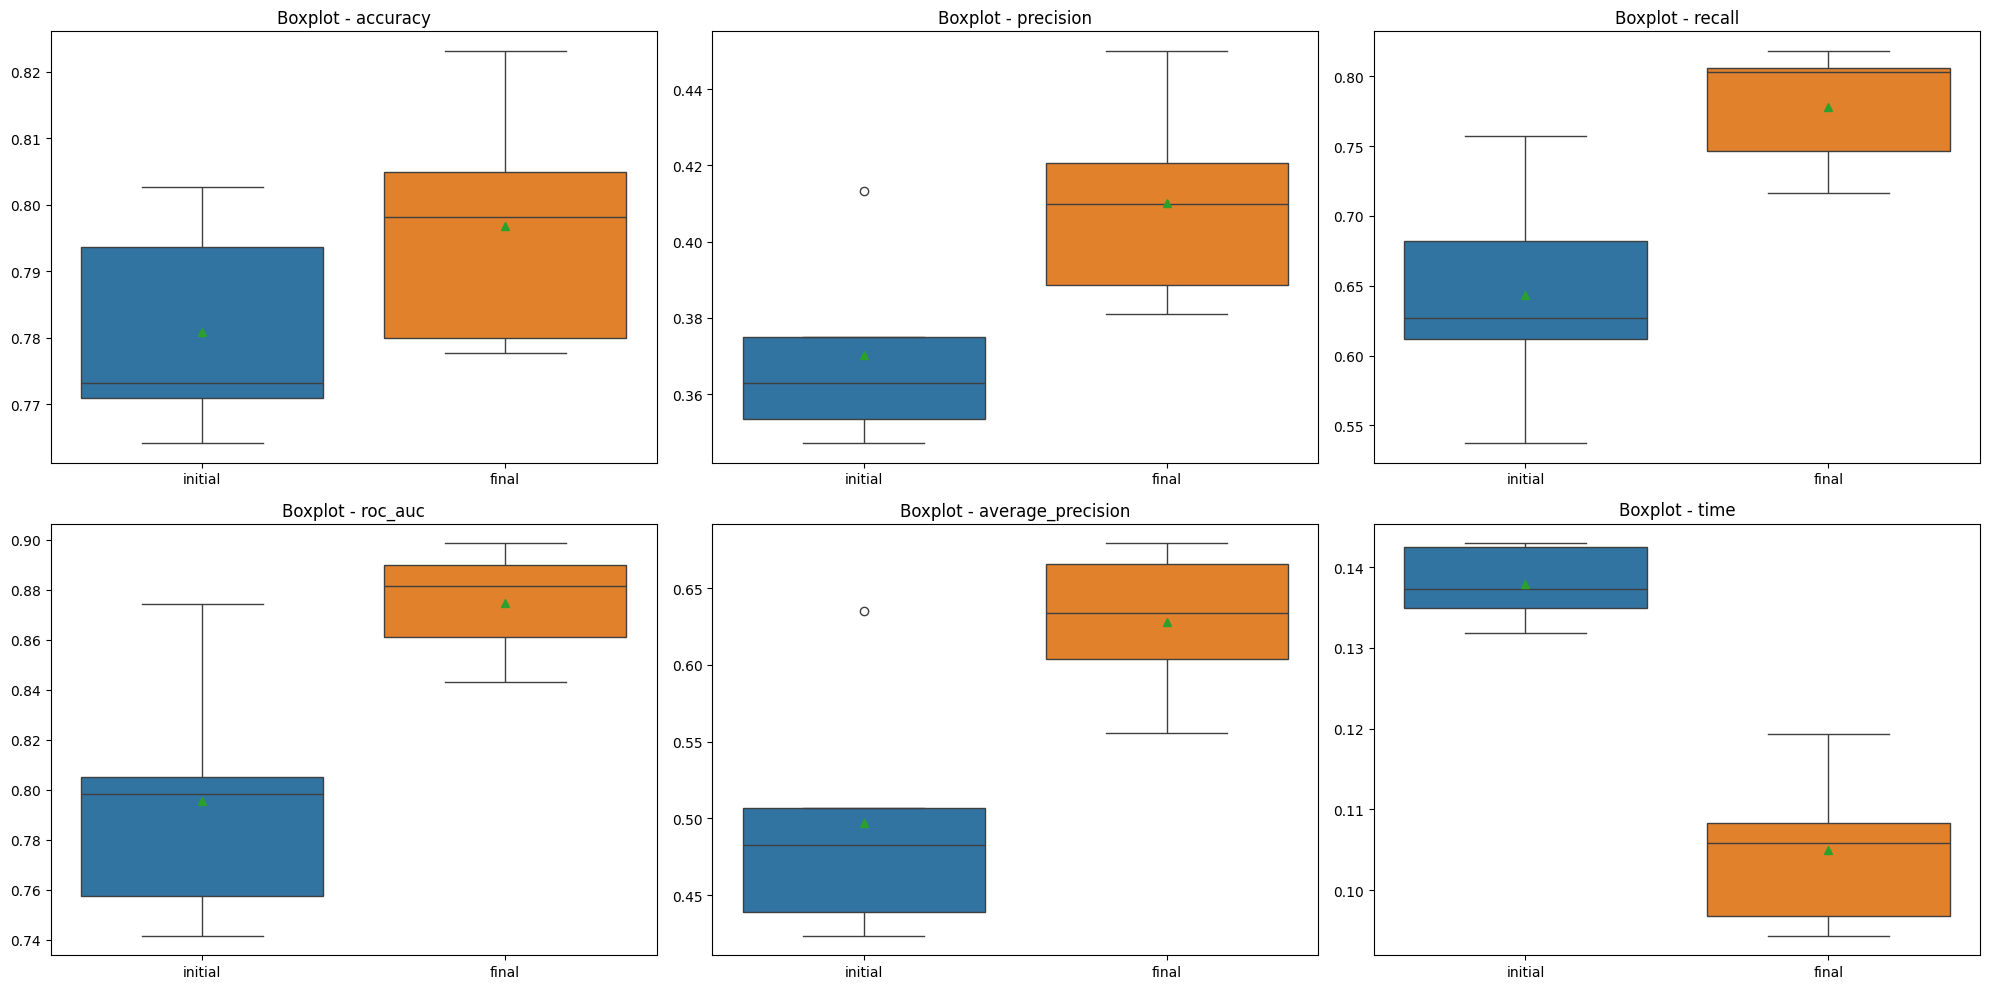

In [31]:
print('- Gráfico: Diagrama de Caixa.')

fn_charts_pandas.boxplot(df_metrics, df_metrics.columns[1:].to_list(), 'results', 'results')

plt.savefig(f'../images/outputs/charts/pyspark/nb08_boxplot_models.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

## 08.7. Exportação do modelo otimizado

### 08.7.1. Salvando o grid search completo para auditoria e reprodutibilidade

In [32]:
joblib.dump(grid_search, consts.GRID_SEARCH_CLASSIFICATION_PYSPARK_JOBLIB) 

['../models/grid_search_classification_pyspark.joblib']

### 08.7.2. Salvando o modelo final treinado com os melhores parâmetros encontrados pelo Grid Search nos formatos joblib e pkl

In [33]:
joblib.dump(pipeline_final, consts.MODEL_CLASSIFICATION_PYSPARK_JOBLIB) 

['../models/model_classification_pyspark.joblib']

In [34]:
joblib.dump(pipeline_final, consts.MODEL_CLASSIFICATION_PYSPARK_PKL) 

['../models/model_classification_pyspark.pkl']